<a href="https://colab.research.google.com/github/vokanev/financial_operation_modeling/blob/main/Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ffn PyPortfolioOpt pymannkendall > /dev/null

# Download DataSet

In [ ]:
!pip install gdown > /dev/null

In [ ]:
!gdown --id 1ktB7fQ8yckHdCkWYEH228E82ogjBX8lY > /dev/null
!gdown --id 1-5NE64jcwsvYMO_t2a4DPNkF0kOle3hY > /dev/null

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ktB7fQ8yckHdCkWYEH228E82ogjBX8lY
To: /content/ticks.csv
100% 46.4M/46.4M [00:00<00:00, 126MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-5NE64jcwsvYMO_t2a4DPNkF0kOle3hY
To: /content/index.csv
100% 30.7k/30.7k [00:00<00:00, 26.0MB/s]


# Eat Sleep Code Repeat

In [ ]:
import pandas as pd
import numpy as np
import ffn
import seaborn as sns
from math import sqrt
from IPython.core.display import HTML
from scipy.stats import norm
import matplotlib.pyplot as plt
import pymannkendall as mk
import scipy
from scipy import stats
%matplotlib inline
np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Universal functions

In [ ]:
def expected_return(coefs: dict, data: pd.DataFrame):
    expected_return = 0
    mean = data.mean()
    for i in coefs.keys():
        expected_return += mean[i] * coefs[i]
    return expected_return

def portfolio_risk(coefs: dict, cov: pd.DataFrame):
    risk = 0
    coefs_new = pd.DataFrame(coefs.values(), index=coefs.keys())
    risk = np.sqrt((coefs_new.T @ cov @ coefs_new)[0][0])
    return risk

def calculate_var_norm(gamma: float, returns: pd.DataFrame):
    VaR = norm.ppf(gamma, (-returns).mean(),  (-returns).std())
    
    return pd.DataFrame(VaR, index=returns.columns, columns=["VaR"])

def calculate_var(gamma: float, returns: pd.DataFrame):
    VaR = (-returns).quantile(gamma)
    return pd.DataFrame(VaR.values, index=returns.columns, columns=["VaR"])

def losses_graph(col: str, data: pd.DataFrame, var_90_per: pd.DataFrame, var_95_per, len1, len2):
    plt.grid()
    sns.distplot(((-data[col])), bins=10)
    plt.plot([var_90_per.loc[col], var_90_per.loc[col]],[0,len1], '--', label='VaR(0.9)')
    plt.plot([var_95_per.loc[col], var_95_per.loc[col]],[0,len2], '--', label='VaR(0.95)')
    plt.legend()
    plt.xlabel('Loss')
    plt.title(f"{col} losses")
    plt.show()

## Задание 1

Скачиваем данные

In [ ]:
data = pd.read_csv("ticks.csv", sep = ";")
index = pd.read_csv("index.csv", sep = ";")
display(HTML(data.head().to_html()))
display(HTML(index.head().to_html()))

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2017-01-03,47.279999,47.340000,46.139999,46.299999,44.741226,6737800,AAL
1,2017-01-04,46.630001,47.439999,46.349998,46.700001,45.127762,5859600,AAL
2,2017-01-05,46.520000,46.930000,45.610001,45.889999,44.345032,6825300,AAL
3,2017-01-06,45.849998,46.720001,45.470001,46.209999,44.654255,7260200,AAL
4,2017-01-09,46.009998,47.340000,45.779999,47.080002,45.494965,4739100,AAL


,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2017-01-03 00:00:00-05:00,5425.620117,5452.569824,5397.990234,5429.080078,5429.080078,1886200000,^IXIC
1,2017-01-04 00:00:00-05:00,5440.910156,5482.350098,5440.240234,5477.000000,5477.000000,1883360000,^IXIC
2,2017-01-05 00:00:00-05:00,5474.390137,5495.850098,5464.359863,5487.939941,5487.939941,1792610000,^IXIC
3,2017-01-06 00:00:00-05:00,5499.080078,5536.520020,5482.810059,5521.060059,5521.060059,1710770000,^IXIC
4,2017-01-09 00:00:00-05:00,5527.580078,5541.080078,5517.140137,5531.819824,5531.819824,1885500000,^IXIC


Нужно взять цену акции закрытия("Close") и объем продаж("Volume")

In [ ]:
dates = sorted(data.Date.unique())
tickers = data.Name.unique()

data_close  = pd.DataFrame(columns = tickers, index = dates)
data_volume = pd.DataFrame(columns = tickers, index = dates)

for ticker in tickers:
    df = pd.DataFrame(data[data.Name == ticker]).set_index("Date")
    data_close[ticker] = df.Close
    data_volume[ticker] = df.Volume

display(HTML(data_close.head().to_html()))
display(HTML(data_volume.head().to_html()))

In [ ]:
data_returns = data_close.to_log_returns()

## Задание 2

Ищем тикеры с недостающими данными, чтобы их отбросить

In [ ]:
data_losses = {i: data_returns[i].isna().sum() for i in tickers}
major_data_loses = {i: data_losses[i] for i in tickers if data_losses[i] > 1}
print(f'Будет отброшено {len(major_data_loses)} актива(ов)')

Будет отброшено 114 актива(ов)


In [ ]:
data_returns_copy = data_returns.copy()
data_returns_copy.drop(major_data_loses.keys(), axis = 1, inplace=True)
data_returns_copy.dropna(axis=0, inplace=True)
clear_data_returns = data_returns_copy.copy()
clear_data_returns

,AAL,AAME,AAOI,AAON,AAPL,AATC,AAWW,ABCB,ABEO,ABIO,...,ZEUS,ZG,ZION,ZIONL,ZIONO,ZIONP,ZIVO,ZUMZ,ZYNE,ZYXI
2017-01-04,0.008602,0.000000,0.017593,0.022240,-0.001120,-0.013793,0.011572,0.021506,0.067659,-0.003697,...,0.046221,-0.002143,0.014256,0.024573,0.043025,0.015994,-0.087011,0.033523,0.048923,0.000000
2017-01-05,-0.017497,-0.062914,-0.030227,-0.029764,0.005072,0.013793,-0.019362,-0.010130,0.045670,0.036368,...,-0.011059,-0.013224,-0.016343,-0.000342,0.008175,-0.006466,-0.095310,-0.099274,0.018397,0.000000
2017-01-06,0.006949,0.062914,-0.017246,-0.012158,0.011087,-0.005495,-0.007851,-0.002265,0.085522,0.000000,...,-0.047580,0.008925,0.006477,-0.006863,-0.007461,0.005798,0.000000,-0.037087,-0.046917,-0.089613
2017-01-09,0.018652,-0.037271,-0.008061,0.003053,0.009118,-0.008299,0.004914,-0.027588,-0.008230,0.017700,...,0.022649,0.002152,-0.010896,0.004809,-0.015816,0.003645,-0.105360,0.005025,-0.013187,0.060625
2017-01-10,0.029303,0.025001,0.027934,0.018127,0.001008,0.008299,0.022299,0.018476,-0.042200,0.000000,...,0.109424,-0.003499,0.015267,0.019346,0.000000,-0.002920,0.000000,0.012453,0.090876,-0.029853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,-0.003796,0.000000,-0.013917,0.006826,0.000000,-0.015748,0.005000,-0.002032,0.058458,0.036368,...,-0.016566,-0.001187,-0.002529,-0.011251,-0.001097,-0.006930,0.095310,-0.002328,0.008326,0.036010
2017-12-26,0.004932,-0.067139,-0.026628,-0.004090,-0.025697,0.000000,-0.005000,-0.011253,0.021842,-0.074108,...,0.002255,-0.006912,-0.009199,0.000000,0.000732,0.000000,-0.095310,0.018476,0.047763,-0.003221
2017-12-27,-0.008551,-0.071974,-0.006446,-0.002736,0.000176,-0.016000,-0.007547,-0.003091,-0.006192,0.045120,...,-0.016807,-0.008406,-0.002954,0.013223,-0.002929,0.001327,0.095310,-0.032561,0.000000,0.000000
2017-12-28,0.001144,-0.030305,0.005160,0.008186,0.002810,-0.032790,-0.004218,0.006173,0.000000,-0.007380,...,-0.005973,-0.003867,0.012347,-0.002631,0.002198,0.000657,-0.200671,0.002361,0.038004,-0.003231


In [ ]:
constant_values = []
for i in clear_data_returns.columns:
    if max(clear_data_returns[i]) == min(clear_data_returns[i]):
        constant_values.append(i)
clear_data_returns.drop(constant_values, axis = 1, inplace=True)

In [ ]:
print(f"data_returns shape: {data_returns.shape}\ndata_returns filtered shape: {clear_data_returns.shape}")

data_returns shape: (251, 1826)
data_returns filtered shape: (250, 1710)


In [ ]:
data_statistics = pd.DataFrame()
data_statistics["Expected return"] = clear_data_returns.mean()
data_statistics["Standard deviation"] = clear_data_returns.std()
display(HTML(data_statistics.T.to_html()))

,AAL,AAME,AAOI,AAON,AAPL,AATC,AAWW,ABCB,ABEO,ABIO,ABMD,ABTX,ACAD,ACER,ACHC,ACHV,ACIW,ACLS,ACNB,ACNT,ACOR,ACRS,ACRX,ACTG,ADBE,ADES,ADI,ADMA,ADMP,ADP,ADSK,ADTN,ADUS,ADVM,AEHR,AEIS,AEMD,AEP,AERI,AEY,AEYE,AGEN,AGFS,AGIO,AGLE,AGNC,AGRX,AGTC,AGYS,AHPI,AIKI,AIMC,AIRG,AIRT,AKAM,AKBA,AKTS,ALBO,ALCO,ALDX,ALGN,ALGT,ALNY,ALOT,ALPN,ALR,ALRM,ALRS,ALTO,AMAT,AMBA,AMCX,AMD,AMED,AMEH,AMGN,AMKR,AMNB,AMOT,AMPH,AMRK,AMRS,AMSC,AMSF,AMSWA,AMTX,AMWD,AMZN,ANDE,ANGI,ANGO,ANIK,ANIP,ANIX,ANSS,APA,APCX,APDN,APEI,APEN,APOG,APPF,APPS,APVO,AQMS,ARAV,ARAY,ARCB,ARCC,ARDX,ARKR,ARLP,AROW,ARTNA,ARTW,ARWR,ASMB,ASPU,ASRT,ASRV,ASTC,ASTE,ASUR,ASYS,ATAX,ATEC,ATEX,ATHX,ATLC,ATLO,ATNI,ATOM,ATOS,ATRA,ATRC,ATRI,ATRO,ATSG,ATVI,ATXS,AUB,AUBN,AVAV,AVEO,AVGO,AVGR,AVID,AVNW,AVT,AVTX,AVXL,AWH,AWRE,AXDX,AXGN,AXON,AXSM,AXTI,AYRO,AYTU,AZPN,AZTA,BANF,BANFP,BANR,BANX,BATRA,BATRK,BBBY,BBGI,BBSI,BCBP,BCDA,BCLI,BCML,BCOR,BCOV,BCPC,BCRX,BECN,BEEM,BELFA,BELFB,BFC,BFIN,BGCP,BGFV,BIIB,BIOC,BIOL,BJRI,BKCC,BKNG,BKR,BKSC,BKYI,BL,BLBD,BLBX,BLCM,BLFS,BLIN,BLKB,BLMN,BLNK,BLPH,BLUE,BMRA,BMRC,BMRN,BNFT,BNTC,BOKF,BOOM,BOTJ,BPMC,BPOP,BPOPM,BPTH,BRFH,BRID,BRKL,BRKR,BRTX,BSET,BSGM,BSQR,BSRR,BTCS,BTX,BUSE,BWEN,BWFG,BYFC,BYRN,CAC,CACC,CAKE,CALA,CALM,CAMP,CANB,CAPR,CAR,CARA,CARE,CARV,CASH,CASI,CASS,CASY,CATC,CATY,CBAN,CBAY,CBFV,CBIO,CBRL,CBSH,CCBG,CCD,CCLP,CCNE,CCOI,CCRN,CCXI,CDMO,CDNA,CDNS,CDTX,CDW,CDXC,CDXS,CDZI,CEAD,CECE,CELH,CELZ,CEMI,CENT,CENTA,CENX,CERS,CETX,CEVA,CFBK,CFFI,CFFN,CFMS,CFRX,CG,CGNX,CGO,CGRN,CHCI,CHCO,CHDN,CHEF,CHI,CHMG,CHRD,CHRS,CHRW,CHSCL,CHSCM,CHSCN,CHSCO,CHSCP,CHTR,CHUY,CHW,CHY,CIDM,CINF,CIVB,CIZN,CKPT,CLAR,CLDX,CLFD,CLIR,CLMT,CLNE,CLPT,CLRB,CLRO,CLSD,CLSK,CLVS,CMCO,CMCSA,CMCT,CME,CMRX,CMTL,CNCE,CNDT,CNFR,CNOB,CNSL,CNTY,CNXN,COCP,CODA,COFS,COHR,COHU,COKE,COLB,COLL,COLM,COMM,COMS,CONN,COOP,CORT,COSM,COST,COUP,COWN,CPHC,CPIX,CPRT,CPRX,CPSH,CPSI,CPSS,CRAI,CRBP,CRDF,CREX,CRIS,CRMD,CRMT,CROX,CRUS,CRVL,CRVS,CRWS,CSBR,CSCO,CSCW,CSGP,CSGS,CSII,CSPI,CSQ,CSTR,CSWC,CSWI,CSX,CTAS,CTBI,CTG,CTHR,CTIB,CTIC,CTLP,CTMX,CTRN,CTSH,CTSO,CTXR,CTXS,CUBA,CUEN,CULL,CUTR,CVBF,CVCO,CVCY,CVGI,CVGW,CVLG,CVLT,CVLY,CVV,CWBC,CWST,CYAN,CYBE,CYCC,CYCCP,CYRN,CYRX,CYTH,CYTK,CZFS,CZNC,CZR,CZWI,DAIO,DAKT,DARE,DCOM,DENN,DFFN,DGICA,DGICB,DGII,DGLY,DHC,DHCNI,DHIL,DIOD,DISH,DJCO,DLHC,DLPN,DLTH,DLTR,DMAC,DMLP,DMRC,DORM,DRRX,DSGR,DSKE,DTST,DVAX,DWSN,DXCM,DXLG,DXPE,DXR,DXYN,DYAI,DYNT,DZSI,EA,EAST,EBAY,EBIX,EBMT,EBTC,ECPG,EDIT,EDSA,EDUC,EEFT,EFOI,EFSC,EGAN,EGBN,EGIO,EGLE,EGRX,EHTH,EIGR,EKSO,ELDN,ELOX,ELSE,EMCF,EMKR,EML,ENG,ENPH,ENSG,ENTA,ENTG,ENVB,EPSN,EQBK,EQIX,ERIE,ERII,ESCA,ESOA,ESPR,ESSA,ETSY,EVBG,EVOK,EWBC,EXAS,EXC,EXEL,EXLS,EXPD,EXPE,EXPO,EXTR,EYPT,EZPW,FANG,FARM,FARO,FAST,FATE,FBIO,FBIZ,FBMS,FBNC,FCAP,FCBC,FCCO,FCEL,FCFS,FCNCA,FCRD,FCUV,FDBC,FDUS,FEIM,FELE,FFBC,FFIC,FFIN,FFIV,FFNW,FFWM,FGBI,FGEN,FGF,FHB,FIBK,FISI,FISV,FITB,FITBI,FIVE,FIVN,FIZZ,FKWL,FLGT,FLIC,FLL,FLNT,FLWS,FLXS,FMAO,FMBH,FMNB,FNCB,FNHC,FNLC,FNWB,FNWD,FOLD,FONR,FORD,FORM,FORR,FOSL,FOXF,FPAY,FRAF,FRBA,FRBK,FRGI,FRME,FRPH,FRPT,FRST,FRTX,FSBW,FSFG,FSLR,FSTR,FSTX,FTAI,FTEK,FTNT,FULT,FUNC,FUND,FUSB,FVCB,FWBI,FWONA,FWONK,FWRD,FXNC,GABC,GAIA,GAIN,GALT,GBDC,GBOX,GBT,GCBC,GDEN,GECC,GEG,GEOS,GERN,GEVO,GIFI,GIII,GILD,GLAD,GLBZ,GLDD,GLPI,GLYC,GMGI,GNSS,GNTX,GNUS,GOGO,GOOD,GOOG,GOOGL,GPP,GPRE,GPRO,GREE,GROW,GRPN,GSBC,GSIT,GT,GTIM,GVP,GWAV,GWRS,GYRO,HA,HAFC,HAIN,HALL,HALO,HAS,HAYN,HBAN,HBCP,HBIO,HBNC,HCCI,HCKT,HCSG,HDSN,HEAR,HEES,HEPA,HFBL,HFWA,HGBL,HGEN,HHS,HIBB,HIFS,HLIT,HMNF,HMST,HNNA,HNRG,HOFT,HOLX,HON,HONE,HOPE,HOVNP,HQI,HQY,HROW,HRTX,HRZN,HSDT,HSIC,HSII,HSKA,HSON,HST,HSTM,HSTO,HTBI,HTBK,HTGM,HTLD,HTLF,HUBG,HURC,HURN,HWBK,HWC,HWKN,IAC,IART,IBCP,IBKR,IBOC,IBRX,IBTX,ICAD,ICCC,ICFI,ICHR,ICMB,ICPT,ICUI,IDCC,IDEX,IDN,IDRA,IDXX,IEA,IEP,IESC,III,ILMN,IMBI,IMGN,IMKTA,IMMR,IMNN,IMUX,INBK,INCY,INDB,INDP,INDT,INFI,INFN,INGN,INO,INOD,INPX,INSE,INSG,INSM,INTC,INTG,INTU,INTZ,INVA,INVE,IONS,IOSP,IOVA,IPAR,IPDN,IPGP,IPWR,IRBT,IRDM,IRIX,IRMD,IROQ,IRTC,IRWD,ISEE,ISIG,ISRG,ISSC,ISTR,ISUN,ITCI,ITI,ITIC,ITRI,IVAC,IVDA,IZEA,JACK,JAGX,JAKK,JAN,JBHT,JBLU,JBSS,JCTCF,JJSF,JKHY,JOUT,JSM,JVA

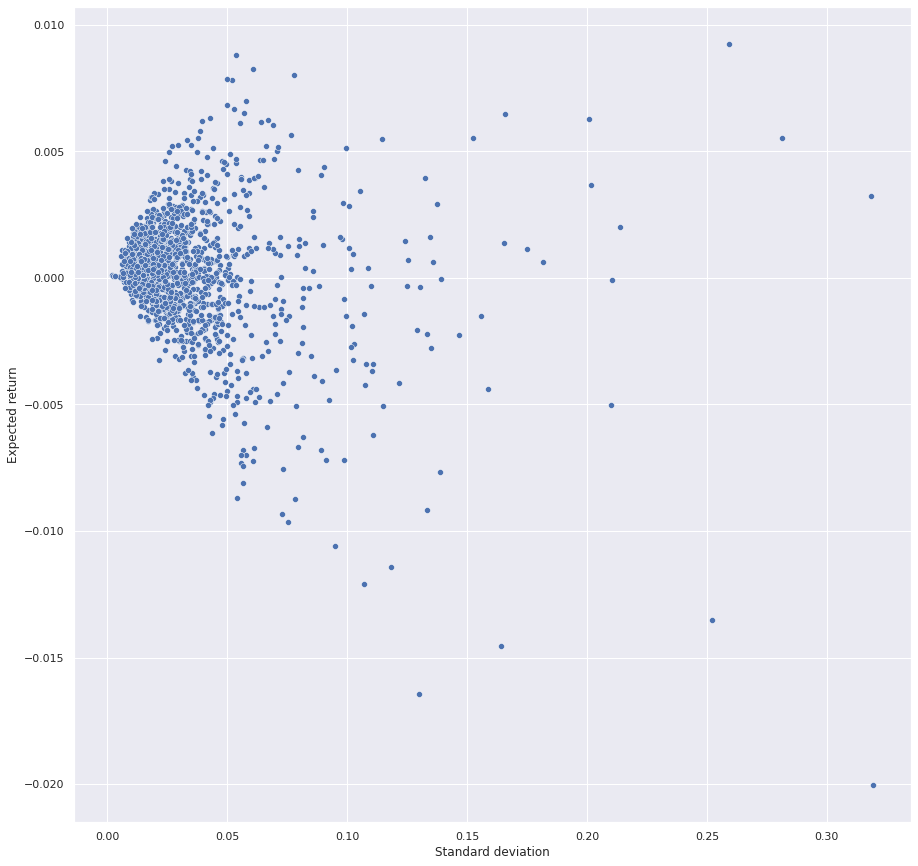

In [ ]:
sns.set(rc={'figure.figsize':(15, 15)})
sns.scatterplot(data=data_statistics, y="Expected return", x="Standard deviation")

In [ ]:
covariance = data_returns_copy.cov()

In [ ]:
var_90_percent = calculate_var(0.9, clear_data_returns)
var_95_percent = calculate_var(0.95, clear_data_returns)

In [ ]:
for gamma in [0.9, 0.95]:
  VaR_cp = calculate_var(gamma, clear_data_returns)
  print(gamma)
  display(HTML(VaR_cp.T.to_html()))
  print('============================================================')

0.9


,AAL,AAME,AAOI,AAON,AAPL,AATC,AAWW,ABCB,ABEO,ABIO,ABMD,ABTX,ACAD,ACER,ACHC,ACHV,ACIW,ACLS,ACNB,ACNT,ACOR,ACRS,ACRX,ACTG,ADBE,ADES,ADI,ADMA,ADMP,ADP,ADSK,ADTN,ADUS,ADVM,AEHR,AEIS,AEMD,AEP,AERI,AEY,AEYE,AGEN,AGFS,AGIO,AGLE,AGNC,AGRX,AGTC,AGYS,AHPI,AIKI,AIMC,AIRG,AIRT,AKAM,AKBA,AKTS,ALBO,ALCO,ALDX,ALGN,ALGT,ALNY,ALOT,ALPN,ALR,ALRM,ALRS,ALTO,AMAT,AMBA,AMCX,AMD,AMED,AMEH,AMGN,AMKR,AMNB,AMOT,AMPH,AMRK,AMRS,AMSC,AMSF,AMSWA,AMTX,AMWD,AMZN,ANDE,ANGI,ANGO,ANIK,ANIP,ANIX,ANSS,APA,APCX,APDN,APEI,APEN,APOG,APPF,APPS,APVO,AQMS,ARAV,ARAY,ARCB,ARCC,ARDX,ARKR,ARLP,AROW,ARTNA,ARTW,ARWR,ASMB,ASPU,ASRT,ASRV,ASTC,ASTE,ASUR,ASYS,ATAX,ATEC,ATEX,ATHX,ATLC,ATLO,ATNI,ATOM,ATOS,ATRA,ATRC,ATRI,ATRO,ATSG,ATVI,ATXS,AUB,AUBN,AVAV,AVEO,AVGO,AVGR,AVID,AVNW,AVT,AVTX,AVXL,AWH,AWRE,AXDX,AXGN,AXON,AXSM,AXTI,AYRO,AYTU,AZPN,AZTA,BANF,BANFP,BANR,BANX,BATRA,BATRK,BBBY,BBGI,BBSI,BCBP,BCDA,BCLI,BCML,BCOR,BCOV,BCPC,BCRX,BECN,BEEM,BELFA,BELFB,BFC,BFIN,BGCP,BGFV,BIIB,BIOC,BIOL,BJRI,BKCC,BKNG,BKR,BKSC,BKYI,BL,BLBD,BLBX,BLCM,BLFS,BLIN,BLKB,BLMN,BLNK,BLPH,BLUE,BMRA,BMRC,BMRN,BNFT,BNTC,BOKF,BOOM,BOTJ,BPMC,BPOP,BPOPM,BPTH,BRFH,BRID,BRKL,BRKR,BRTX,BSET,BSGM,BSQR,BSRR,BTCS,BTX,BUSE,BWEN,BWFG,BYFC,BYRN,CAC,CACC,CAKE,CALA,CALM,CAMP,CANB,CAPR,CAR,CARA,CARE,CARV,CASH,CASI,CASS,CASY,CATC,CATY,CBAN,CBAY,CBFV,CBIO,CBRL,CBSH,CCBG,CCD,CCLP,CCNE,CCOI,CCRN,CCXI,CDMO,CDNA,CDNS,CDTX,CDW,CDXC,CDXS,CDZI,CEAD,CECE,CELH,CELZ,CEMI,CENT,CENTA,CENX,CERS,CETX,CEVA,CFBK,CFFI,CFFN,CFMS,CFRX,CG,CGNX,CGO,CGRN,CHCI,CHCO,CHDN,CHEF,CHI,CHMG,CHRD,CHRS,CHRW,CHSCL,CHSCM,CHSCN,CHSCO,CHSCP,CHTR,CHUY,CHW,CHY,CIDM,CINF,CIVB,CIZN,CKPT,CLAR,CLDX,CLFD,CLIR,CLMT,CLNE,CLPT,CLRB,CLRO,CLSD,CLSK,CLVS,CMCO,CMCSA,CMCT,CME,CMRX,CMTL,CNCE,CNDT,CNFR,CNOB,CNSL,CNTY,CNXN,COCP,CODA,COFS,COHR,COHU,COKE,COLB,COLL,COLM,COMM,COMS,CONN,COOP,CORT,COSM,COST,COUP,COWN,CPHC,CPIX,CPRT,CPRX,CPSH,CPSI,CPSS,CRAI,CRBP,CRDF,CREX,CRIS,CRMD,CRMT,CROX,CRUS,CRVL,CRVS,CRWS,CSBR,CSCO,CSCW,CSGP,CSGS,CSII,CSPI,CSQ,CSTR,CSWC,CSWI,CSX,CTAS,CTBI,CTG,CTHR,CTIB,CTIC,CTLP,CTMX,CTRN,CTSH,CTSO,CTXR,CTXS,CUBA,CUEN,CULL,CUTR,CVBF,CVCO,CVCY,CVGI,CVGW,CVLG,CVLT,CVLY,CVV,CWBC,CWST,CYAN,CYBE,CYCC,CYCCP,CYRN,CYRX,CYTH,CYTK,CZFS,CZNC,CZR,CZWI,DAIO,DAKT,DARE,DCOM,DENN,DFFN,DGICA,DGICB,DGII,DGLY,DHC,DHCNI,DHIL,DIOD,DISH,DJCO,DLHC,DLPN,DLTH,DLTR,DMAC,DMLP,DMRC,DORM,DRRX,DSGR,DSKE,DTST,DVAX,DWSN,DXCM,DXLG,DXPE,DXR,DXYN,DYAI,DYNT,DZSI,EA,EAST,EBAY,EBIX,EBMT,EBTC,ECPG,EDIT,EDSA,EDUC,EEFT,EFOI,EFSC,EGAN,EGBN,EGIO,EGLE,EGRX,EHTH,EIGR,EKSO,ELDN,ELOX,ELSE,EMCF,EMKR,EML,ENG,ENPH,ENSG,ENTA,ENTG,ENVB,EPSN,EQBK,EQIX,ERIE,ERII,ESCA,ESOA,ESPR,ESSA,ETSY,EVBG,EVOK,EWBC,EXAS,EXC,EXEL,EXLS,EXPD,EXPE,EXPO,EXTR,EYPT,EZPW,FANG,FARM,FARO,FAST,FATE,FBIO,FBIZ,FBMS,FBNC,FCAP,FCBC,FCCO,FCEL,FCFS,FCNCA,FCRD,FCUV,FDBC,FDUS,FEIM,FELE,FFBC,FFIC,FFIN,FFIV,FFNW,FFWM,FGBI,FGEN,FGF,FHB,FIBK,FISI,FISV,FITB,FITBI,FIVE,FIVN,FIZZ,FKWL,FLGT,FLIC,FLL,FLNT,FLWS,FLXS,FMAO,FMBH,FMNB,FNCB,FNHC,FNLC,FNWB,FNWD,FOLD,FONR,FORD,FORM,FORR,FOSL,FOXF,FPAY,FRAF,FRBA,FRBK,FRGI,FRME,FRPH,FRPT,FRST,FRTX,FSBW,FSFG,FSLR,FSTR,FSTX,FTAI,FTEK,FTNT,FULT,FUNC,FUND,FUSB,FVCB,FWBI,FWONA,FWONK,FWRD,FXNC,GABC,GAIA,GAIN,GALT,GBDC,GBOX,GBT,GCBC,GDEN,GECC,GEG,GEOS,GERN,GEVO,GIFI,GIII,GILD,GLAD,GLBZ,GLDD,GLPI,GLYC,GMGI,GNSS,GNTX,GNUS,GOGO,GOOD,GOOG,GOOGL,GPP,GPRE,GPRO,GREE,GROW,GRPN,GSBC,GSIT,GT,GTIM,GVP,GWAV,GWRS,GYRO,HA,HAFC,HAIN,HALL,HALO,HAS,HAYN,HBAN,HBCP,HBIO,HBNC,HCCI,HCKT,HCSG,HDSN,HEAR,HEES,HEPA,HFBL,HFWA,HGBL,HGEN,HHS,HIBB,HIFS,HLIT,HMNF,HMST,HNNA,HNRG,HOFT,HOLX,HON,HONE,HOPE,HOVNP,HQI,HQY,HROW,HRTX,HRZN,HSDT,HSIC,HSII,HSKA,HSON,HST,HSTM,HSTO,HTBI,HTBK,HTGM,HTLD,HTLF,HUBG,HURC,HURN,HWBK,HWC,HWKN,IAC,IART,IBCP,IBKR,IBOC,IBRX,IBTX,ICAD,ICCC,ICFI,ICHR,ICMB,ICPT,ICUI,IDCC,IDEX,IDN,IDRA,IDXX,IEA,IEP,IESC,III,ILMN,IMBI,IMGN,IMKTA,IMMR,IMNN,IMUX,INBK,INCY,INDB,INDP,INDT,INFI,INFN,INGN,INO,INOD,INPX,INSE,INSG,INSM,INTC,INTG,INTU,INTZ,INVA,INVE,IONS,IOSP,IOVA,IPAR,IPDN,IPGP,IPWR,IRBT,IRDM,IRIX,IRMD,IROQ,IRTC,IRWD,ISEE,ISIG,ISRG,ISSC,ISTR,ISUN,ITCI,ITI,ITIC,ITRI,IVAC,IVDA,IZEA,JACK,JAGX,JAKK,JAN,JBHT,JBLU,JBSS,JCTCF,JJSF,JKHY,JOUT,JSM,JVA

0.95


,AAL,AAME,AAOI,AAON,AAPL,AATC,AAWW,ABCB,ABEO,ABIO,ABMD,ABTX,ACAD,ACER,ACHC,ACHV,ACIW,ACLS,ACNB,ACNT,ACOR,ACRS,ACRX,ACTG,ADBE,ADES,ADI,ADMA,ADMP,ADP,ADSK,ADTN,ADUS,ADVM,AEHR,AEIS,AEMD,AEP,AERI,AEY,AEYE,AGEN,AGFS,AGIO,AGLE,AGNC,AGRX,AGTC,AGYS,AHPI,AIKI,AIMC,AIRG,AIRT,AKAM,AKBA,AKTS,ALBO,ALCO,ALDX,ALGN,ALGT,ALNY,ALOT,ALPN,ALR,ALRM,ALRS,ALTO,AMAT,AMBA,AMCX,AMD,AMED,AMEH,AMGN,AMKR,AMNB,AMOT,AMPH,AMRK,AMRS,AMSC,AMSF,AMSWA,AMTX,AMWD,AMZN,ANDE,ANGI,ANGO,ANIK,ANIP,ANIX,ANSS,APA,APCX,APDN,APEI,APEN,APOG,APPF,APPS,APVO,AQMS,ARAV,ARAY,ARCB,ARCC,ARDX,ARKR,ARLP,AROW,ARTNA,ARTW,ARWR,ASMB,ASPU,ASRT,ASRV,ASTC,ASTE,ASUR,ASYS,ATAX,ATEC,ATEX,ATHX,ATLC,ATLO,ATNI,ATOM,ATOS,ATRA,ATRC,ATRI,ATRO,ATSG,ATVI,ATXS,AUB,AUBN,AVAV,AVEO,AVGO,AVGR,AVID,AVNW,AVT,AVTX,AVXL,AWH,AWRE,AXDX,AXGN,AXON,AXSM,AXTI,AYRO,AYTU,AZPN,AZTA,BANF,BANFP,BANR,BANX,BATRA,BATRK,BBBY,BBGI,BBSI,BCBP,BCDA,BCLI,BCML,BCOR,BCOV,BCPC,BCRX,BECN,BEEM,BELFA,BELFB,BFC,BFIN,BGCP,BGFV,BIIB,BIOC,BIOL,BJRI,BKCC,BKNG,BKR,BKSC,BKYI,BL,BLBD,BLBX,BLCM,BLFS,BLIN,BLKB,BLMN,BLNK,BLPH,BLUE,BMRA,BMRC,BMRN,BNFT,BNTC,BOKF,BOOM,BOTJ,BPMC,BPOP,BPOPM,BPTH,BRFH,BRID,BRKL,BRKR,BRTX,BSET,BSGM,BSQR,BSRR,BTCS,BTX,BUSE,BWEN,BWFG,BYFC,BYRN,CAC,CACC,CAKE,CALA,CALM,CAMP,CANB,CAPR,CAR,CARA,CARE,CARV,CASH,CASI,CASS,CASY,CATC,CATY,CBAN,CBAY,CBFV,CBIO,CBRL,CBSH,CCBG,CCD,CCLP,CCNE,CCOI,CCRN,CCXI,CDMO,CDNA,CDNS,CDTX,CDW,CDXC,CDXS,CDZI,CEAD,CECE,CELH,CELZ,CEMI,CENT,CENTA,CENX,CERS,CETX,CEVA,CFBK,CFFI,CFFN,CFMS,CFRX,CG,CGNX,CGO,CGRN,CHCI,CHCO,CHDN,CHEF,CHI,CHMG,CHRD,CHRS,CHRW,CHSCL,CHSCM,CHSCN,CHSCO,CHSCP,CHTR,CHUY,CHW,CHY,CIDM,CINF,CIVB,CIZN,CKPT,CLAR,CLDX,CLFD,CLIR,CLMT,CLNE,CLPT,CLRB,CLRO,CLSD,CLSK,CLVS,CMCO,CMCSA,CMCT,CME,CMRX,CMTL,CNCE,CNDT,CNFR,CNOB,CNSL,CNTY,CNXN,COCP,CODA,COFS,COHR,COHU,COKE,COLB,COLL,COLM,COMM,COMS,CONN,COOP,CORT,COSM,COST,COUP,COWN,CPHC,CPIX,CPRT,CPRX,CPSH,CPSI,CPSS,CRAI,CRBP,CRDF,CREX,CRIS,CRMD,CRMT,CROX,CRUS,CRVL,CRVS,CRWS,CSBR,CSCO,CSCW,CSGP,CSGS,CSII,CSPI,CSQ,CSTR,CSWC,CSWI,CSX,CTAS,CTBI,CTG,CTHR,CTIB,CTIC,CTLP,CTMX,CTRN,CTSH,CTSO,CTXR,CTXS,CUBA,CUEN,CULL,CUTR,CVBF,CVCO,CVCY,CVGI,CVGW,CVLG,CVLT,CVLY,CVV,CWBC,CWST,CYAN,CYBE,CYCC,CYCCP,CYRN,CYRX,CYTH,CYTK,CZFS,CZNC,CZR,CZWI,DAIO,DAKT,DARE,DCOM,DENN,DFFN,DGICA,DGICB,DGII,DGLY,DHC,DHCNI,DHIL,DIOD,DISH,DJCO,DLHC,DLPN,DLTH,DLTR,DMAC,DMLP,DMRC,DORM,DRRX,DSGR,DSKE,DTST,DVAX,DWSN,DXCM,DXLG,DXPE,DXR,DXYN,DYAI,DYNT,DZSI,EA,EAST,EBAY,EBIX,EBMT,EBTC,ECPG,EDIT,EDSA,EDUC,EEFT,EFOI,EFSC,EGAN,EGBN,EGIO,EGLE,EGRX,EHTH,EIGR,EKSO,ELDN,ELOX,ELSE,EMCF,EMKR,EML,ENG,ENPH,ENSG,ENTA,ENTG,ENVB,EPSN,EQBK,EQIX,ERIE,ERII,ESCA,ESOA,ESPR,ESSA,ETSY,EVBG,EVOK,EWBC,EXAS,EXC,EXEL,EXLS,EXPD,EXPE,EXPO,EXTR,EYPT,EZPW,FANG,FARM,FARO,FAST,FATE,FBIO,FBIZ,FBMS,FBNC,FCAP,FCBC,FCCO,FCEL,FCFS,FCNCA,FCRD,FCUV,FDBC,FDUS,FEIM,FELE,FFBC,FFIC,FFIN,FFIV,FFNW,FFWM,FGBI,FGEN,FGF,FHB,FIBK,FISI,FISV,FITB,FITBI,FIVE,FIVN,FIZZ,FKWL,FLGT,FLIC,FLL,FLNT,FLWS,FLXS,FMAO,FMBH,FMNB,FNCB,FNHC,FNLC,FNWB,FNWD,FOLD,FONR,FORD,FORM,FORR,FOSL,FOXF,FPAY,FRAF,FRBA,FRBK,FRGI,FRME,FRPH,FRPT,FRST,FRTX,FSBW,FSFG,FSLR,FSTR,FSTX,FTAI,FTEK,FTNT,FULT,FUNC,FUND,FUSB,FVCB,FWBI,FWONA,FWONK,FWRD,FXNC,GABC,GAIA,GAIN,GALT,GBDC,GBOX,GBT,GCBC,GDEN,GECC,GEG,GEOS,GERN,GEVO,GIFI,GIII,GILD,GLAD,GLBZ,GLDD,GLPI,GLYC,GMGI,GNSS,GNTX,GNUS,GOGO,GOOD,GOOG,GOOGL,GPP,GPRE,GPRO,GREE,GROW,GRPN,GSBC,GSIT,GT,GTIM,GVP,GWAV,GWRS,GYRO,HA,HAFC,HAIN,HALL,HALO,HAS,HAYN,HBAN,HBCP,HBIO,HBNC,HCCI,HCKT,HCSG,HDSN,HEAR,HEES,HEPA,HFBL,HFWA,HGBL,HGEN,HHS,HIBB,HIFS,HLIT,HMNF,HMST,HNNA,HNRG,HOFT,HOLX,HON,HONE,HOPE,HOVNP,HQI,HQY,HROW,HRTX,HRZN,HSDT,HSIC,HSII,HSKA,HSON,HST,HSTM,HSTO,HTBI,HTBK,HTGM,HTLD,HTLF,HUBG,HURC,HURN,HWBK,HWC,HWKN,IAC,IART,IBCP,IBKR,IBOC,IBRX,IBTX,ICAD,ICCC,ICFI,ICHR,ICMB,ICPT,ICUI,IDCC,IDEX,IDN,IDRA,IDXX,IEA,IEP,IESC,III,ILMN,IMBI,IMGN,IMKTA,IMMR,IMNN,IMUX,INBK,INCY,INDB,INDP,INDT,INFI,INFN,INGN,INO,INOD,INPX,INSE,INSG,INSM,INTC,INTG,INTU,INTZ,INVA,INVE,IONS,IOSP,IOVA,IPAR,IPDN,IPGP,IPWR,IRBT,IRDM,IRIX,IRMD,IROQ,IRTC,IRWD,ISEE,ISIG,ISRG,ISSC,ISTR,ISUN,ITCI,ITI,ITIC,ITRI,IVAC,IVDA,IZEA,JACK,JAGX,JAKK,JAN,JBHT,JBLU,JBSS,JCTCF,JJSF,JKHY,JOUT,JSM,JVA

## Задание 3

Портфель с равными долями

In [ ]:
covariance = clear_data_returns.cov()

copy_columns = clear_data_returns.columns
equal_shares_coefs = {i: 1. / len(copy_columns) for i in copy_columns}
equal_shares_expected_return = expected_return(equal_shares_coefs, clear_data_returns)
equal_shares_risk = portfolio_risk(equal_shares_coefs, covariance)

print(f"Expected return: {equal_shares_expected_return}\nRisk: {equal_shares_risk}")

Expected return: 0.00017789806248474197
Risk: 0.006099099306567352


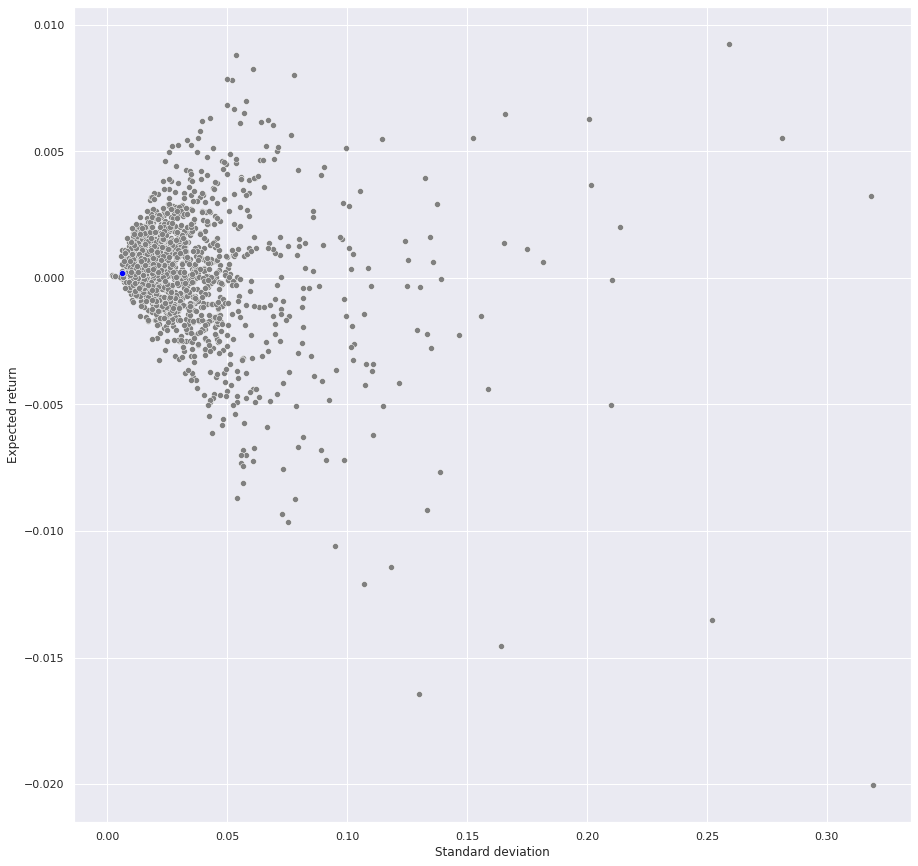

In [ ]:
equal_shares_statistics = pd.DataFrame(data=[equal_shares_expected_return, equal_shares_risk], index=["Expected return", "Standard deviation"]).T


sns.set(rc={'figure.figsize':(15, 15)})
sns.scatterplot(data=data_statistics , y="Expected return", x="Standard deviation", color='grey')
sns.scatterplot(data=equal_shares_statistics, y="Expected return", x="Standard deviation", color='blue')

In [ ]:
gammas = [0.9, 0.95]
for gamma in gammas:
    print(gamma)
    display(HTML(pd.DataFrame(calculate_var(gamma, clear_data_returns).head()).to_html()))
    print("================================================")

0.9


,VaR
AAL,0.020013
AAME,0.039794
AAOI,0.044210
AAON,0.016900
AAPL,0.009826


0.95


,VaR
AAL,0.031306
AAME,0.059065
AAOI,0.055097
AAON,0.027272
AAPL,0.015062


Характеристика портфеля: При выборе портфеля с равными долями на рынке NASDAQ легко заметить, что портфель обладает низкой доходностью, но при этом также риск не превышает 0.01

## Задание 4

Индекс рынка

In [ ]:
index_copy = index.copy()

index_close  = pd.DataFrame(columns = ["^IXIC"], index = dates)
index_volume = pd.DataFrame(columns = ["^IXIC"], index = dates)

df = pd.DataFrame(index_copy[index_copy.Name == "^IXIC"])
df.set_index("Date", inplace=True)
index_close["^IXIC"] = df.Close
index_volume["^IXIC"] = df.Volume

for i in range(len(df.Close)):
    index_close["^IXIC"][i] = df.Close[i]
    index_volume["^IXIC"][i] = df.Volume[i]

In [ ]:
print("index_close")
display(HTML(index_close.head().to_html()))

print("index_volume")
display(HTML(index_volume.head().to_html()))

index_close


,^IXIC
2017-01-03,5429.080078
2017-01-04,5477.000000
2017-01-05,5487.939941
2017-01-06,5521.060059
2017-01-09,5531.819824


index_volume


,^IXIC
2017-01-03,1.886200e+09
2017-01-04,1.883360e+09
2017-01-05,1.792610e+09
2017-01-06,1.710770e+09
2017-01-09,1.885500e+09


In [ ]:
index_returns = index_close.to_log_returns()
index_returns_copy = index_returns.copy().dropna()
display(HTML(index_returns_copy.head().to_html()))

,^IXIC
2017-01-04,0.008788
2017-01-05,0.001995
2017-01-06,0.006017
2017-01-09,0.001947
2017-01-10,0.003609


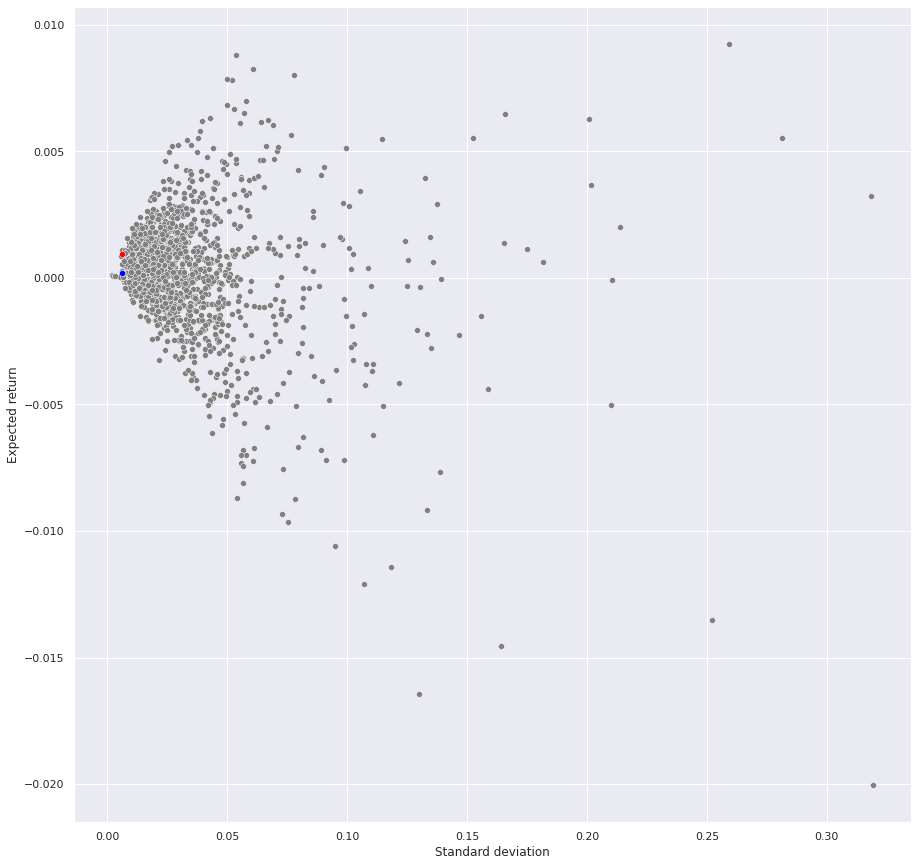

In [ ]:
index_statistics = pd.DataFrame()
index_statistics["Expected return"] = index_returns_copy.mean()
index_statistics["Standard deviation"] = index_returns_copy.std()

sns.set(rc={'figure.figsize':(15, 15)})
sns.scatterplot(data=data_statistics , y="Expected return", x="Standard deviation", color='grey')
sns.scatterplot(data=equal_shares_statistics, y="Expected return", x="Standard deviation", color='blue')
sns.scatterplot(data=index_statistics , y="Expected return", x="Standard deviation", color='red')

In [ ]:
print(f"Expected return: {index_statistics['Expected return']}\nRisk: {index_statistics['Standard deviation']}")

Expected return: ^IXIC    0.000961
Name: Expected return, dtype: float64
Risk: ^IXIC    0.006044
Name: Standard deviation, dtype: float64


In [ ]:
for gamma in gammas:
    print(gamma)
    display(HTML(calculate_var(gamma, index_returns_copy).to_html()))
    print("============")

0.9


,VaR
^IXIC,0.005243


0.95


,VaR
^IXIC,0.008285


Характеристика индекса рынка: Индекс рынка, в сравнении с портфелем с равными долями, является более прибыльным (выше доходность), и также риск этого портфеля, как и в случае с портфелем с равными долями, не превышает 0.01

## Задание 5

Задайте уровень риска и оцените VaR (Value at Risk = Сумма под Риском для случайных величин Потери = - Доходности) для активов вашего рынка. Какой из активов наиболее предпочтителен по этой характеристике? Где он расположен на карте активов? Дайте характеристику VaR портфеля с равными долями и индекса рынка.

In [ ]:
for gamma in gammas:
    print(gamma)
    vars = calculate_var(gamma, clear_data_returns).T
    vars = vars.dropna(1)
    print(f'Min VaR = {vars.columns[np.argmin(vars)]}, {vars[vars.columns[np.argmin(vars)]]}')
    display(HTML(calculate_var(gamma, clear_data_returns).T.to_html()))
    print("=================================================================")
    

0.9
Min VaR = BLBX, VaR    0.0
Name: BLBX, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  after removing the cwd from sys.path.


,AAL,AAME,AAOI,AAON,AAPL,AATC,AAWW,ABCB,ABEO,ABIO,ABMD,ABTX,ACAD,ACER,ACHC,ACHV,ACIW,ACLS,ACNB,ACNT,ACOR,ACRS,ACRX,ACTG,ADBE,ADES,ADI,ADMA,ADMP,ADP,ADSK,ADTN,ADUS,ADVM,AEHR,AEIS,AEMD,AEP,AERI,AEY,AEYE,AGEN,AGFS,AGIO,AGLE,AGNC,AGRX,AGTC,AGYS,AHPI,AIKI,AIMC,AIRG,AIRT,AKAM,AKBA,AKTS,ALBO,ALCO,ALDX,ALGN,ALGT,ALNY,ALOT,ALPN,ALR,ALRM,ALRS,ALTO,AMAT,AMBA,AMCX,AMD,AMED,AMEH,AMGN,AMKR,AMNB,AMOT,AMPH,AMRK,AMRS,AMSC,AMSF,AMSWA,AMTX,AMWD,AMZN,ANDE,ANGI,ANGO,ANIK,ANIP,ANIX,ANSS,APA,APCX,APDN,APEI,APEN,APOG,APPF,APPS,APVO,AQMS,ARAV,ARAY,ARCB,ARCC,ARDX,ARKR,ARLP,AROW,ARTNA,ARTW,ARWR,ASMB,ASPU,ASRT,ASRV,ASTC,ASTE,ASUR,ASYS,ATAX,ATEC,ATEX,ATHX,ATLC,ATLO,ATNI,ATOM,ATOS,ATRA,ATRC,ATRI,ATRO,ATSG,ATVI,ATXS,AUB,AUBN,AVAV,AVEO,AVGO,AVGR,AVID,AVNW,AVT,AVTX,AVXL,AWH,AWRE,AXDX,AXGN,AXON,AXSM,AXTI,AYRO,AYTU,AZPN,AZTA,BANF,BANFP,BANR,BANX,BATRA,BATRK,BBBY,BBGI,BBSI,BCBP,BCDA,BCLI,BCML,BCOR,BCOV,BCPC,BCRX,BECN,BEEM,BELFA,BELFB,BFC,BFIN,BGCP,BGFV,BIIB,BIOC,BIOL,BJRI,BKCC,BKNG,BKR,BKSC,BKYI,BL,BLBD,BLBX,BLCM,BLFS,BLIN,BLKB,BLMN,BLNK,BLPH,BLUE,BMRA,BMRC,BMRN,BNFT,BNTC,BOKF,BOOM,BOTJ,BPMC,BPOP,BPOPM,BPTH,BRFH,BRID,BRKL,BRKR,BRTX,BSET,BSGM,BSQR,BSRR,BTCS,BTX,BUSE,BWEN,BWFG,BYFC,BYRN,CAC,CACC,CAKE,CALA,CALM,CAMP,CANB,CAPR,CAR,CARA,CARE,CARV,CASH,CASI,CASS,CASY,CATC,CATY,CBAN,CBAY,CBFV,CBIO,CBRL,CBSH,CCBG,CCD,CCLP,CCNE,CCOI,CCRN,CCXI,CDMO,CDNA,CDNS,CDTX,CDW,CDXC,CDXS,CDZI,CEAD,CECE,CELH,CELZ,CEMI,CENT,CENTA,CENX,CERS,CETX,CEVA,CFBK,CFFI,CFFN,CFMS,CFRX,CG,CGNX,CGO,CGRN,CHCI,CHCO,CHDN,CHEF,CHI,CHMG,CHRD,CHRS,CHRW,CHSCL,CHSCM,CHSCN,CHSCO,CHSCP,CHTR,CHUY,CHW,CHY,CIDM,CINF,CIVB,CIZN,CKPT,CLAR,CLDX,CLFD,CLIR,CLMT,CLNE,CLPT,CLRB,CLRO,CLSD,CLSK,CLVS,CMCO,CMCSA,CMCT,CME,CMRX,CMTL,CNCE,CNDT,CNFR,CNOB,CNSL,CNTY,CNXN,COCP,CODA,COFS,COHR,COHU,COKE,COLB,COLL,COLM,COMM,COMS,CONN,COOP,CORT,COSM,COST,COUP,COWN,CPHC,CPIX,CPRT,CPRX,CPSH,CPSI,CPSS,CRAI,CRBP,CRDF,CREX,CRIS,CRMD,CRMT,CROX,CRUS,CRVL,CRVS,CRWS,CSBR,CSCO,CSCW,CSGP,CSGS,CSII,CSPI,CSQ,CSTR,CSWC,CSWI,CSX,CTAS,CTBI,CTG,CTHR,CTIB,CTIC,CTLP,CTMX,CTRN,CTSH,CTSO,CTXR,CTXS,CUBA,CUEN,CULL,CUTR,CVBF,CVCO,CVCY,CVGI,CVGW,CVLG,CVLT,CVLY,CVV,CWBC,CWST,CYAN,CYBE,CYCC,CYCCP,CYRN,CYRX,CYTH,CYTK,CZFS,CZNC,CZR,CZWI,DAIO,DAKT,DARE,DCOM,DENN,DFFN,DGICA,DGICB,DGII,DGLY,DHC,DHCNI,DHIL,DIOD,DISH,DJCO,DLHC,DLPN,DLTH,DLTR,DMAC,DMLP,DMRC,DORM,DRRX,DSGR,DSKE,DTST,DVAX,DWSN,DXCM,DXLG,DXPE,DXR,DXYN,DYAI,DYNT,DZSI,EA,EAST,EBAY,EBIX,EBMT,EBTC,ECPG,EDIT,EDSA,EDUC,EEFT,EFOI,EFSC,EGAN,EGBN,EGIO,EGLE,EGRX,EHTH,EIGR,EKSO,ELDN,ELOX,ELSE,EMCF,EMKR,EML,ENG,ENPH,ENSG,ENTA,ENTG,ENVB,EPSN,EQBK,EQIX,ERIE,ERII,ESCA,ESOA,ESPR,ESSA,ETSY,EVBG,EVOK,EWBC,EXAS,EXC,EXEL,EXLS,EXPD,EXPE,EXPO,EXTR,EYPT,EZPW,FANG,FARM,FARO,FAST,FATE,FBIO,FBIZ,FBMS,FBNC,FCAP,FCBC,FCCO,FCEL,FCFS,FCNCA,FCRD,FCUV,FDBC,FDUS,FEIM,FELE,FFBC,FFIC,FFIN,FFIV,FFNW,FFWM,FGBI,FGEN,FGF,FHB,FIBK,FISI,FISV,FITB,FITBI,FIVE,FIVN,FIZZ,FKWL,FLGT,FLIC,FLL,FLNT,FLWS,FLXS,FMAO,FMBH,FMNB,FNCB,FNHC,FNLC,FNWB,FNWD,FOLD,FONR,FORD,FORM,FORR,FOSL,FOXF,FPAY,FRAF,FRBA,FRBK,FRGI,FRME,FRPH,FRPT,FRST,FRTX,FSBW,FSFG,FSLR,FSTR,FSTX,FTAI,FTEK,FTNT,FULT,FUNC,FUND,FUSB,FVCB,FWBI,FWONA,FWONK,FWRD,FXNC,GABC,GAIA,GAIN,GALT,GBDC,GBOX,GBT,GCBC,GDEN,GECC,GEG,GEOS,GERN,GEVO,GIFI,GIII,GILD,GLAD,GLBZ,GLDD,GLPI,GLYC,GMGI,GNSS,GNTX,GNUS,GOGO,GOOD,GOOG,GOOGL,GPP,GPRE,GPRO,GREE,GROW,GRPN,GSBC,GSIT,GT,GTIM,GVP,GWAV,GWRS,GYRO,HA,HAFC,HAIN,HALL,HALO,HAS,HAYN,HBAN,HBCP,HBIO,HBNC,HCCI,HCKT,HCSG,HDSN,HEAR,HEES,HEPA,HFBL,HFWA,HGBL,HGEN,HHS,HIBB,HIFS,HLIT,HMNF,HMST,HNNA,HNRG,HOFT,HOLX,HON,HONE,HOPE,HOVNP,HQI,HQY,HROW,HRTX,HRZN,HSDT,HSIC,HSII,HSKA,HSON,HST,HSTM,HSTO,HTBI,HTBK,HTGM,HTLD,HTLF,HUBG,HURC,HURN,HWBK,HWC,HWKN,IAC,IART,IBCP,IBKR,IBOC,IBRX,IBTX,ICAD,ICCC,ICFI,ICHR,ICMB,ICPT,ICUI,IDCC,IDEX,IDN,IDRA,IDXX,IEA,IEP,IESC,III,ILMN,IMBI,IMGN,IMKTA,IMMR,IMNN,IMUX,INBK,INCY,INDB,INDP,INDT,INFI,INFN,INGN,INO,INOD,INPX,INSE,INSG,INSM,INTC,INTG,INTU,INTZ,INVA,INVE,IONS,IOSP,IOVA,IPAR,IPDN,IPGP,IPWR,IRBT,IRDM,IRIX,IRMD,IROQ,IRTC,IRWD,ISEE,ISIG,ISRG,ISSC,ISTR,ISUN,ITCI,ITI,ITIC,ITRI,IVAC,IVDA,IZEA,JACK,JAGX,JAKK,JAN,JBHT,JBLU,JBSS,JCTCF,JJSF,JKHY,JOUT,JSM,JVA

0.95
Min VaR = BLBX, VaR   -0.0
Name: BLBX, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  after removing the cwd from sys.path.


,AAL,AAME,AAOI,AAON,AAPL,AATC,AAWW,ABCB,ABEO,ABIO,ABMD,ABTX,ACAD,ACER,ACHC,ACHV,ACIW,ACLS,ACNB,ACNT,ACOR,ACRS,ACRX,ACTG,ADBE,ADES,ADI,ADMA,ADMP,ADP,ADSK,ADTN,ADUS,ADVM,AEHR,AEIS,AEMD,AEP,AERI,AEY,AEYE,AGEN,AGFS,AGIO,AGLE,AGNC,AGRX,AGTC,AGYS,AHPI,AIKI,AIMC,AIRG,AIRT,AKAM,AKBA,AKTS,ALBO,ALCO,ALDX,ALGN,ALGT,ALNY,ALOT,ALPN,ALR,ALRM,ALRS,ALTO,AMAT,AMBA,AMCX,AMD,AMED,AMEH,AMGN,AMKR,AMNB,AMOT,AMPH,AMRK,AMRS,AMSC,AMSF,AMSWA,AMTX,AMWD,AMZN,ANDE,ANGI,ANGO,ANIK,ANIP,ANIX,ANSS,APA,APCX,APDN,APEI,APEN,APOG,APPF,APPS,APVO,AQMS,ARAV,ARAY,ARCB,ARCC,ARDX,ARKR,ARLP,AROW,ARTNA,ARTW,ARWR,ASMB,ASPU,ASRT,ASRV,ASTC,ASTE,ASUR,ASYS,ATAX,ATEC,ATEX,ATHX,ATLC,ATLO,ATNI,ATOM,ATOS,ATRA,ATRC,ATRI,ATRO,ATSG,ATVI,ATXS,AUB,AUBN,AVAV,AVEO,AVGO,AVGR,AVID,AVNW,AVT,AVTX,AVXL,AWH,AWRE,AXDX,AXGN,AXON,AXSM,AXTI,AYRO,AYTU,AZPN,AZTA,BANF,BANFP,BANR,BANX,BATRA,BATRK,BBBY,BBGI,BBSI,BCBP,BCDA,BCLI,BCML,BCOR,BCOV,BCPC,BCRX,BECN,BEEM,BELFA,BELFB,BFC,BFIN,BGCP,BGFV,BIIB,BIOC,BIOL,BJRI,BKCC,BKNG,BKR,BKSC,BKYI,BL,BLBD,BLBX,BLCM,BLFS,BLIN,BLKB,BLMN,BLNK,BLPH,BLUE,BMRA,BMRC,BMRN,BNFT,BNTC,BOKF,BOOM,BOTJ,BPMC,BPOP,BPOPM,BPTH,BRFH,BRID,BRKL,BRKR,BRTX,BSET,BSGM,BSQR,BSRR,BTCS,BTX,BUSE,BWEN,BWFG,BYFC,BYRN,CAC,CACC,CAKE,CALA,CALM,CAMP,CANB,CAPR,CAR,CARA,CARE,CARV,CASH,CASI,CASS,CASY,CATC,CATY,CBAN,CBAY,CBFV,CBIO,CBRL,CBSH,CCBG,CCD,CCLP,CCNE,CCOI,CCRN,CCXI,CDMO,CDNA,CDNS,CDTX,CDW,CDXC,CDXS,CDZI,CEAD,CECE,CELH,CELZ,CEMI,CENT,CENTA,CENX,CERS,CETX,CEVA,CFBK,CFFI,CFFN,CFMS,CFRX,CG,CGNX,CGO,CGRN,CHCI,CHCO,CHDN,CHEF,CHI,CHMG,CHRD,CHRS,CHRW,CHSCL,CHSCM,CHSCN,CHSCO,CHSCP,CHTR,CHUY,CHW,CHY,CIDM,CINF,CIVB,CIZN,CKPT,CLAR,CLDX,CLFD,CLIR,CLMT,CLNE,CLPT,CLRB,CLRO,CLSD,CLSK,CLVS,CMCO,CMCSA,CMCT,CME,CMRX,CMTL,CNCE,CNDT,CNFR,CNOB,CNSL,CNTY,CNXN,COCP,CODA,COFS,COHR,COHU,COKE,COLB,COLL,COLM,COMM,COMS,CONN,COOP,CORT,COSM,COST,COUP,COWN,CPHC,CPIX,CPRT,CPRX,CPSH,CPSI,CPSS,CRAI,CRBP,CRDF,CREX,CRIS,CRMD,CRMT,CROX,CRUS,CRVL,CRVS,CRWS,CSBR,CSCO,CSCW,CSGP,CSGS,CSII,CSPI,CSQ,CSTR,CSWC,CSWI,CSX,CTAS,CTBI,CTG,CTHR,CTIB,CTIC,CTLP,CTMX,CTRN,CTSH,CTSO,CTXR,CTXS,CUBA,CUEN,CULL,CUTR,CVBF,CVCO,CVCY,CVGI,CVGW,CVLG,CVLT,CVLY,CVV,CWBC,CWST,CYAN,CYBE,CYCC,CYCCP,CYRN,CYRX,CYTH,CYTK,CZFS,CZNC,CZR,CZWI,DAIO,DAKT,DARE,DCOM,DENN,DFFN,DGICA,DGICB,DGII,DGLY,DHC,DHCNI,DHIL,DIOD,DISH,DJCO,DLHC,DLPN,DLTH,DLTR,DMAC,DMLP,DMRC,DORM,DRRX,DSGR,DSKE,DTST,DVAX,DWSN,DXCM,DXLG,DXPE,DXR,DXYN,DYAI,DYNT,DZSI,EA,EAST,EBAY,EBIX,EBMT,EBTC,ECPG,EDIT,EDSA,EDUC,EEFT,EFOI,EFSC,EGAN,EGBN,EGIO,EGLE,EGRX,EHTH,EIGR,EKSO,ELDN,ELOX,ELSE,EMCF,EMKR,EML,ENG,ENPH,ENSG,ENTA,ENTG,ENVB,EPSN,EQBK,EQIX,ERIE,ERII,ESCA,ESOA,ESPR,ESSA,ETSY,EVBG,EVOK,EWBC,EXAS,EXC,EXEL,EXLS,EXPD,EXPE,EXPO,EXTR,EYPT,EZPW,FANG,FARM,FARO,FAST,FATE,FBIO,FBIZ,FBMS,FBNC,FCAP,FCBC,FCCO,FCEL,FCFS,FCNCA,FCRD,FCUV,FDBC,FDUS,FEIM,FELE,FFBC,FFIC,FFIN,FFIV,FFNW,FFWM,FGBI,FGEN,FGF,FHB,FIBK,FISI,FISV,FITB,FITBI,FIVE,FIVN,FIZZ,FKWL,FLGT,FLIC,FLL,FLNT,FLWS,FLXS,FMAO,FMBH,FMNB,FNCB,FNHC,FNLC,FNWB,FNWD,FOLD,FONR,FORD,FORM,FORR,FOSL,FOXF,FPAY,FRAF,FRBA,FRBK,FRGI,FRME,FRPH,FRPT,FRST,FRTX,FSBW,FSFG,FSLR,FSTR,FSTX,FTAI,FTEK,FTNT,FULT,FUNC,FUND,FUSB,FVCB,FWBI,FWONA,FWONK,FWRD,FXNC,GABC,GAIA,GAIN,GALT,GBDC,GBOX,GBT,GCBC,GDEN,GECC,GEG,GEOS,GERN,GEVO,GIFI,GIII,GILD,GLAD,GLBZ,GLDD,GLPI,GLYC,GMGI,GNSS,GNTX,GNUS,GOGO,GOOD,GOOG,GOOGL,GPP,GPRE,GPRO,GREE,GROW,GRPN,GSBC,GSIT,GT,GTIM,GVP,GWAV,GWRS,GYRO,HA,HAFC,HAIN,HALL,HALO,HAS,HAYN,HBAN,HBCP,HBIO,HBNC,HCCI,HCKT,HCSG,HDSN,HEAR,HEES,HEPA,HFBL,HFWA,HGBL,HGEN,HHS,HIBB,HIFS,HLIT,HMNF,HMST,HNNA,HNRG,HOFT,HOLX,HON,HONE,HOPE,HOVNP,HQI,HQY,HROW,HRTX,HRZN,HSDT,HSIC,HSII,HSKA,HSON,HST,HSTM,HSTO,HTBI,HTBK,HTGM,HTLD,HTLF,HUBG,HURC,HURN,HWBK,HWC,HWKN,IAC,IART,IBCP,IBKR,IBOC,IBRX,IBTX,ICAD,ICCC,ICFI,ICHR,ICMB,ICPT,ICUI,IDCC,IDEX,IDN,IDRA,IDXX,IEA,IEP,IESC,III,ILMN,IMBI,IMGN,IMKTA,IMMR,IMNN,IMUX,INBK,INCY,INDB,INDP,INDT,INFI,INFN,INGN,INO,INOD,INPX,INSE,INSG,INSM,INTC,INTG,INTU,INTZ,INVA,INVE,IONS,IOSP,IOVA,IPAR,IPDN,IPGP,IPWR,IRBT,IRDM,IRIX,IRMD,IROQ,IRTC,IRWD,ISEE,ISIG,ISRG,ISSC,ISTR,ISUN,ITCI,ITI,ITIC,ITRI,IVAC,IVDA,IZEA,JACK,JAGX,JAKK,JAN,JBHT,JBLU,JBSS,JCTCF,JJSF,JKHY,JOUT,JSM,JVA

При gamma = 0.9 и gamma = 0.95 наиболее предпрочтительным активом является . Покажем его на карте активов пурпурным цветом

      Expected return  Standard deviation
BLBX         0.001467            0.023483


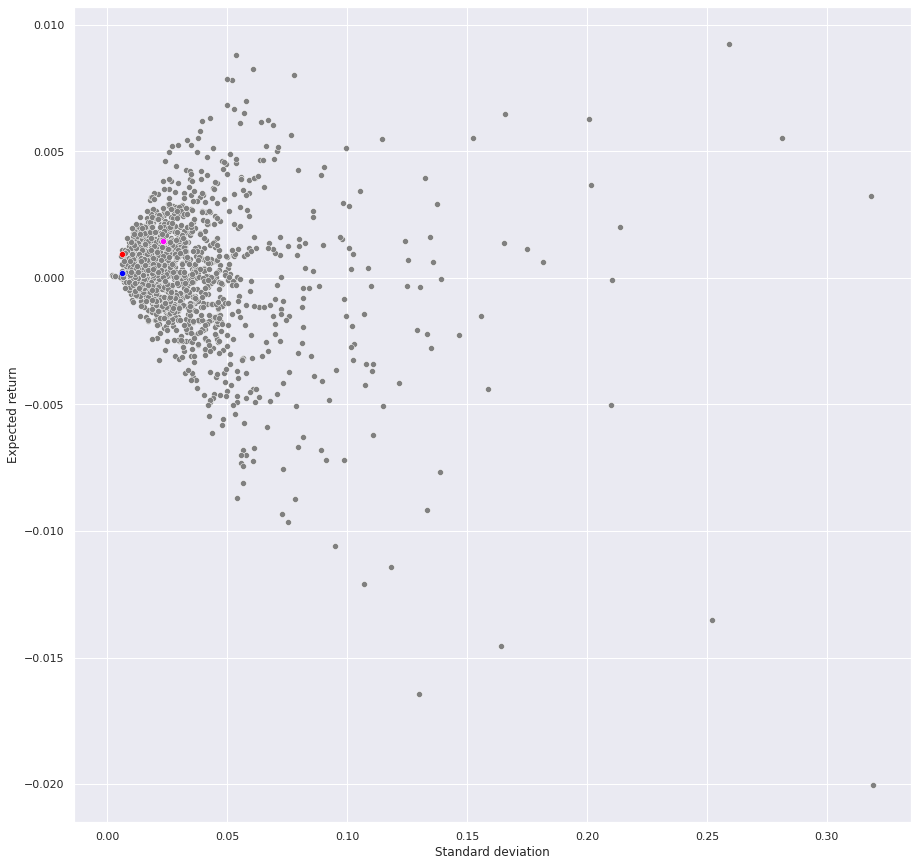

In [ ]:
min_var_statistics = pd.DataFrame(data=data_statistics.loc[vars.columns[np.argmin(vars)]], index=["Expected return", "Standard deviation"]).T
print(min_var_statistics)
sns.set(rc={'figure.figsize':(15, 15)})
sns.scatterplot(data=data_statistics , y="Expected return", x="Standard deviation", color='grey')
sns.scatterplot(data=equal_shares_statistics, y="Expected return", x="Standard deviation", color='blue')
sns.scatterplot(data=index_statistics , y="Expected return", x="Standard deviation", color='red')
sns.scatterplot(data=min_var_statistics, y="Expected return", x="Standard deviation", color='magenta')

Наиболее предпочтительным активом по характеристике VaR является актив BLBX (Blackboxstocks) c VaR = 0.0 при gamma = 0.9 и VaR = -0.0 при gamma = 0.95. Как мы видим на графике данный актив имеет больший риск при небольшом увеличении доходности, по сравнению с индексом рынка.

## Задание 6

Выберите несколько интересных (4-6) активов рынка. Можно ли считать наблюдаемые доходности (объемы продаж) конкретного актива повторной выборкой из некоторого распределения (белый шум)? Поищите научные подходы к ответу на этот вопрос (проверка гипотезы о случайности, Ивченко Г.И. Медведев Ю.И. Введение в математическую статистику)

,2017-01-04,2017-01-05,2017-01-06,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-17,2017-01-18,2017-01-19,2017-01-20,2017-01-23,2017-01-24,2017-01-25,2017-01-26,2017-01-27,2017-01-30,2017-01-31,2017-02-01,2017-02-02,2017-02-03,2017-02-06,2017-02-07,2017-02-08,2017-02-09,2017-02-10,2017-02-13,2017-02-14,2017-02-15,2017-02-16,2017-02-17,2017-02-21,2017-02-22,2017-02-23,2017-02-24,2017-02-27,2017-02-28,2017-03-01,2017-03-02,2017-03-03,2017-03-06,2017-03-07,2017-03-08,2017-03-09,2017-03-10,2017-03-13,2017-03-14,2017-03-15,2017-03-16,2017-03-17,2017-03-20,2017-03-21,2017-03-22,2017-03-23,2017-03-24,2017-03-27,2017-03-28,2017-03-29,2017-03-30,2017-03-31,2017-04-03,2017-04-04,2017-04-05,2017-04-06,2017-04-07,2017-04-10,2017-04-11,2017-04-12,2017-04-13,2017-04-17,2017-04-18,2017-04-19,2017-04-20,2017-04-21,2017-04-24,2017-04-25,2017-04-26,2017-04-27,2017-04-28,2017-05-01,2017-05-02,2017-05-03,2017-05-04,2017-05-05,2017-05-08,2017-05-09,2017-05-10,2017-05-11,2017-05-12,2017-05-15,2017-05-16,2017-05-17,2017-05-18,2017-05-19,2017-05-22,2017-05-23,2017-05-24,2017-05-25,2017-05-26,2017-05-30,2017-05-31,2017-06-01,2017-06-02,2017-06-05,2017-06-06,2017-06-07,2017-06-08,2017-06-09,2017-06-12,2017-06-13,2017-06-14,2017-06-15,2017-06-16,2017-06-19,2017-06-20,2017-06-21,2017-06-22,2017-06-23,2017-06-26,2017-06-27,2017-06-28,2017-06-29,2017-06-30,2017-07-03,2017-07-05,2017-07-06,2017-07-07,2017-07-10,2017-07-11,2017-07-12,2017-07-13,2017-07-14,2017-07-17,2017-07-18,2017-07-19,2017-07-20,2017-07-21,2017-07-24,2017-07-25,2017-07-26,2017-07-27,2017-07-28,2017-07-31,2017-08-01,2017-08-02,2017-08-03,2017-08-04,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-11,2017-09-12,2017-09-13,2017-09-14,2017-09-15,2017-09-18,2017-09-19,2017-09-20,2017-09-21,2017-09-22,2017-09-25,2017-09-26,2017-09-27,2017-09-28,2017-09-29,2017-10-02,2017-10-03,2017-10-04,2017-10-05,2017-10-06,2017-10-09,2017-10-10,2017-10-11,2017-10-12,2017-10-13,2017-10-16,2017-10-17,2017-10-18,2017-10-19,2017-10-20,2017-10-23,2017-10-24,2017-10-25,2017-10-26,2017-10-27,2017-10-30,2017-10-31,2017-11-01,2017-11-02,2017-11-03,2017-11-06,2017-11-07,2017-11-08,2017-11-09,2017-11-10,2017-11-13,2017-11-14,2017-11-15,2017-11-16,2017-11-17,2017-11-20,2017-11-21,2017-11-22,2017-11-24,2017-11-27,2017-11-28,2017-11-29,2017-11-30,2017-12-01,2017-12-04,2017-12-05,2017-12-06,2017-12-07,2017-12-08,2017-12-11,2017-12-12,2017-12-13,2017-12-14,2017-12-15,2017-12-18,2017-12-19,2017-12-20,2017-12-21,2017-12-22,2017-12-26,2017-12-27,2017-12-28,2017-12-29
AAPL,-0.001120,0.005072,0.011087,0.009118,0.001008,0.005359,-0.004184,-0.001763,0.008032,-0.000083,-0.001752,0.001835,0.000666,-0.000916,0.015795,0.000492,0.000082,-0.002627,-0.002305,0.059194,-0.001710,0.004270,0.009330,0.009472,0.003870,0.002874,-0.002268,0.008817,0.012896,0.003622,-0.001181,0.002730,0.007195,0.002995,-0.004239,0.000952,0.001974,0.000438,0.020233,-0.005955,0.005884,-0.003153,0.001291,-0.003734,-0.002305,0.003312,0.000431,-0.001510,0.010521,0.001636,-0.004988,0.010446,-0.011518,0.011235,-0.003542,-0.001989,0.001705,0.020515,0.002223,-0.001319,-0.001878,0.000278,0.007419,-0.005194,-0.002503,-0.002230,-0.001187,-0.010815,0.001200,-0.005303,0.005515,-0.004452,-0.003690,0.012433,-0.001194,0.009583,0.006177,-0.005899,0.000765,-0.000974,0.020192,0.006325,-0.003055,-0.003610,0.016448,0.026825,0.006384,-0.004752,0.004492,0.013869,-0.002566,-0.001478,-0.034152,0.015126,0.003403,0.006058,-0.001235,-0.002995,0.003450,-0.001691,0.000391,-0.005939,0.002746,0.014710,-0.009826,0.003372,0.005939,-0.002449,-0.039549,-0.024186,0.008013,-0.009803,-0.006011,-0.014098,0.028206,-0.009130,0.005913,-0.001647,0.004453,-0.003150,-0.014437,0.014505,-0.014853,0.002364,-0.003617,0.004103,-0.009483,0.010108,0.006085,0.003235,0.001442,0.01383

,Expected return,Standard deviation
AAPL,0.001506,0.011110
ROST,0.000806,0.014491
HBAN,0.000356,0.014056
RIOT,0.008025,0.077883
CHRW,0.000805,0.011713
HAIN,0.000286,0.017250


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


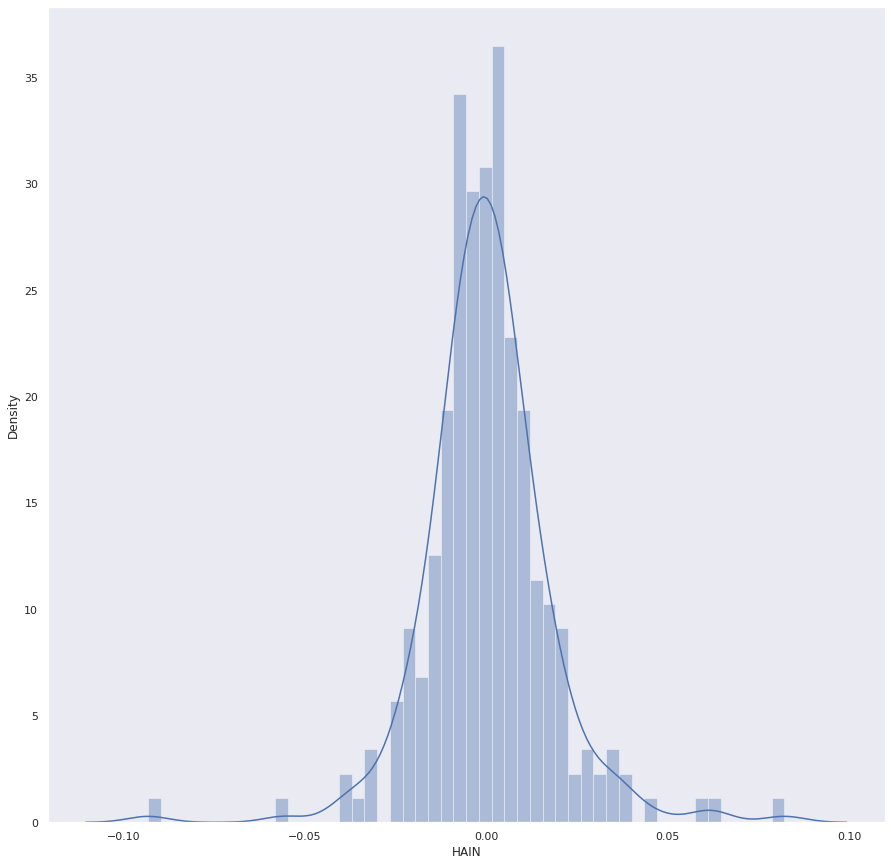

In [ ]:
#Выберем AAPL - технологии (108538270.91633466), ROST -  одежда (2914732.270916335), HBAN - банкинг (9434442.629482072), RIOT - майнинговая компания(1457196.4143426295), CHRW - логистика (1516497.2111553785), HAIN - еда (1726495.6175298805) по среднему объему продаж акций из разных секторов 
choosen_stocks = ['AAPL', 'ROST', 'HBAN', 'RIOT', 'CHRW', 'HAIN']
returns_of_choosen_stocks = pd.DataFrame()
returns_of_choosen_stocks = clear_data_returns.loc[:, choosen_stocks]

display(HTML(pd.DataFrame(returns_of_choosen_stocks).T.to_html()))
display(HTML(pd.DataFrame(data_statistics.loc[choosen_stocks]).to_html()))

plt.grid()
sns.distplot(returns_of_choosen_stocks['HAIN'], bins=50)
plt.show()


https://vsp.pnnl.gov/help/vsample/design_trend_mann_kendall.htm

In [ ]:
print('returns\n')
for i in choosen_stocks:
    result = mk.original_test(clear_data_returns[i], alpha=0.05)
    print(f"{i} : {result}")
print("\n")

example_stocks = ["UPLD", "URBN"]
for i in example_stocks:
    result = mk.original_test(clear_data_returns[i], alpha=0.05)
    print(f"{i} : {result}")

print('\nvolume\n')
for i in choosen_stocks:
    result = mk.original_test(data_volume[i], alpha=0.05)
    print(f"{i} : {result}")
print("\n")

example_stocks = ["UPLD", "URBN"]
for i in example_stocks:
    result = mk.original_test(data_volume[i], alpha=0.05)
    print(f"{i} : {result}")

returns

AAPL : Mann_Kendall_Test(trend='no trend', h=False, p=0.19989829045624607, z=-1.2818413929012171, Tau=-0.05445783132530121, s=-1695.0, var_s=1746458.3333333333, slope=-9.92845327661872e-06, intercept=0.0018154267881649977)
ROST : Mann_Kendall_Test(trend='no trend', h=False, p=0.24023856956290812, z=1.174390697628506, Tau=0.04989558232931727, s=1553.0, var_s=1746458.3333333333, slope=1.157274934811896e-05, intercept=-0.0008372929713534263)
HBAN : Mann_Kendall_Test(trend='no trend', h=False, p=0.5264948099032734, z=0.6333657743255906, Tau=0.026923694779116467, s=838.0, var_s=1746392.0, slope=6.988615311846821e-06, intercept=-0.0008700826063249292)
RIOT : Mann_Kendall_Test(trend='no trend', h=False, p=0.09565601212579677, z=1.6662882689838967, Tau=0.07077911646586345, s=2203.0, var_s=1746362.3333333333, slope=7.211250971137095e-05, intercept=-0.0077908402359917125)
CHRW : Mann_Kendall_Test(trend='no trend', h=False, p=0.12066625535627806, z=1.5519831503423822, Tau=0.0659277108433

Интересным является факт, что при отсутствии трендов у доходности выбранных акций, у 5 из 6 наблюдается тренд в объеме продаж акций. Также стоит заметить, что у акции UPLD несмотря тренд о снижении доходности, виден тренд на повышение объема продаж.

In [ ]:
data_statistics.loc[example_stocks]

,Expected return,Standard deviation
UPLD,0.003517,0.023892
URBN,0.000817,0.025767


## Задание 7

Выберите несколько интересных (значимых)  активов рынка из разных производственных секторов.   В предположении, что наблюдаемые доходности (объемы продаж) являются повторной выборкой из некоторого распределения исследовать (выборочно) распределения доходностей и объемов продаж выбранных активов. Сделать выводы

In [ ]:
choosen_stocks = ['AAPL', 'ROST', 'CAC', 'RIOT', 'CHRW', 'HAIN']
normal_returns = []
normal_volume = []
alpha = 0.05

for i in choosen_stocks:
    stat_returns, p_returns = scipy.stats.normaltest(data_returns_copy[i])
    stat_volume, p_volume = scipy.stats.normaltest(data_volume[i]) 
    print(i)
    print('\tStatistics = %.3f, p-value = %.3f' % (stat_returns, p_returns))
    if p_returns > alpha:
        normal_returns.append(i)
        print('\tПринять гипотезу о нормальности распределения доходности')
    else:
        print('\tОтклонить гипотезу о нормальности распределения доходности')

    print('\n\tStatistics = %.3f, p-value = %.3f' % (stat_volume, p_volume))

    if p_volume > alpha:
        normal_volume(i)
        print('\tПринять гипотезу о нормальности распределения объемов продаж')
    else:
        print('\tОтклонить гипотезу о нормальности распределения объемов продаж')

AAPL
	Statistics = 40.787, p-value = 0.000
	Отклонить гипотезу о нормальности распределения доходности

	Statistics = 189.802, p-value = 0.000
	Отклонить гипотезу о нормальности распределения объемов продаж
ROST
	Statistics = 163.516, p-value = 0.000
	Отклонить гипотезу о нормальности распределения доходности

	Statistics = 185.005, p-value = 0.000
	Отклонить гипотезу о нормальности распределения объемов продаж
CAC
	Statistics = 3.329, p-value = 0.189
	Принять гипотезу о нормальности распределения доходности

	Statistics = 150.877, p-value = 0.000
	Отклонить гипотезу о нормальности распределения объемов продаж
RIOT
	Statistics = 79.967, p-value = 0.000
	Отклонить гипотезу о нормальности распределения доходности

	Statistics = 265.248, p-value = 0.000
	Отклонить гипотезу о нормальности распределения объемов продаж
CHRW
	Statistics = 72.285, p-value = 0.000
	Отклонить гипотезу о нормальности распределения доходности

	Statistics = 243.015, p-value = 0.000
	Отклонить гипотезу о нормальнос

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


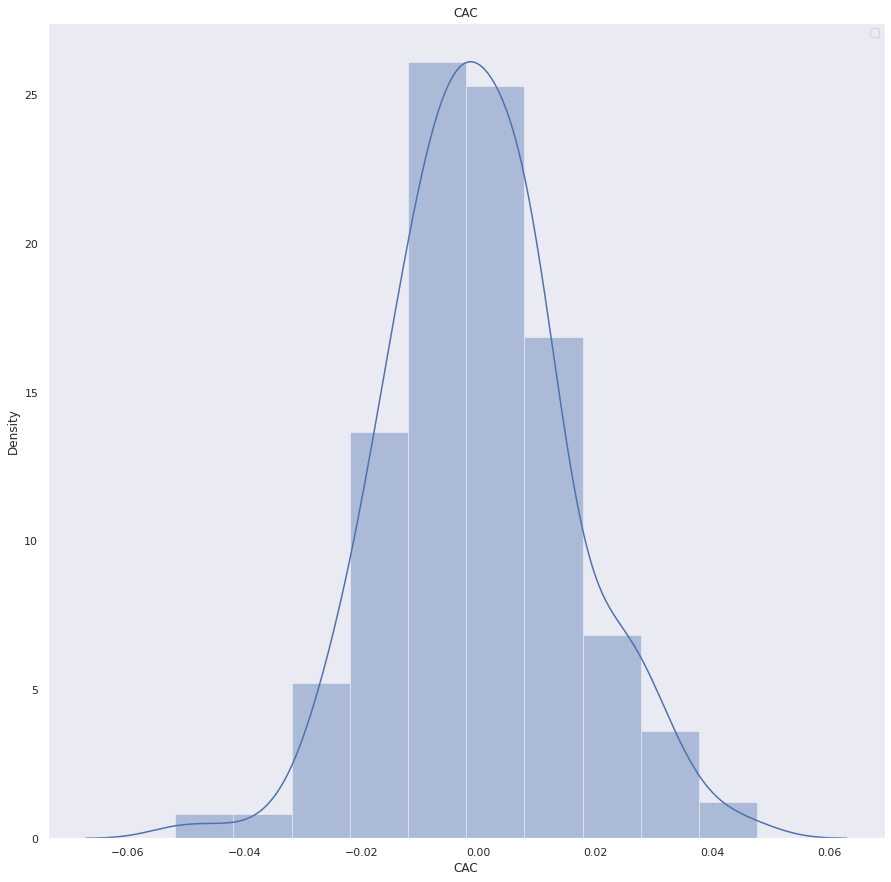

In [ ]:
if len(normal_returns) > 0:
    plt.grid()
    sns.distplot(((-data_returns_copy[normal_returns[0]])), bins=10)
    plt.legend()
    plt.title(f"{normal_returns[0]}")
    plt.show()

if len(normal_volume) > 0:
    plt.grid()
    sns.distplot(((-data_returns_copy[normal_volume[0]])), bins=10)
    plt.legend()
    plt.title(f"{normal_volume[0]}")
    plt.show()

## Задание 8

Исследовать зависимости (выборочно) между доходностями различных активов с помощью техники анализа зависимостей. Сделайте анализ зависимостей между парами активов для активов из одного производственного сектора и для активов из разных производственных секторов. Сделайте анализ зависимости (выборочно) между доходностями и объемами продаж одного актива. Рассмотрите активы из разных производственных секторов. 


In [ ]:
def dependence_test(returns: pd.DataFrame, sells_volume: pd.DataFrame, tickers_arr_1, tickers_arr_2, alpha):
  for i in tickers_arr_1:
      for j in tickers_arr_2:
          if i == j:
              continue
          print(f"\n{i} : {j}")
          stat_returns, p_returns = stats.ttest_ind(returns[i], returns[j], equal_var=False)
          stat_volume, p_volume = stats.ttest_ind(sells_volume[i], sells_volume[j], equal_var=False)

          print('\tStatistics = %.3f, p-value = %.3f' % (stat_returns, p_returns))
          if p_returns > alpha:
              print('\tПринять гипотезу об однородности распределения доходности')
          else:
              print('\tОтклонить гипотезу об однородности распределения доходности')

          print('\n\tStatistics = %.3f, p-value = %.3f' % (stat_volume, p_volume))

          if p_volume > alpha:
              print('\tПринять гипотезу об однородности распределения объемов продаж')
          else:
              print('\tОтклонить гипотезу об однородности распределения объемов продаж')

In [ ]:
tech_sector = ["AAPL", "GOOG", "TSCO"]
energy_sector = ["FANG", "BKR", "APA"]

dependence_test(clear_data_returns, data_volume, tech_sector, tech_sector, 0.05)
print('===========================================================================================================================')
dependence_test(clear_data_returns, data_volume, energy_sector, energy_sector, 0.05)


AAPL : GOOG
	Statistics = 0.388, p-value = 0.698
	Принять гипотезу об однородности распределения доходности

	Statistics = 26.673, p-value = 0.000
	Отклонить гипотезу об однородности распределения объемов продаж

AAPL : TSCO
	Statistics = 1.257, p-value = 0.209
	Принять гипотезу об однородности распределения доходности

	Statistics = 37.296, p-value = 0.000
	Отклонить гипотезу об однородности распределения объемов продаж

GOOG : AAPL
	Statistics = -0.388, p-value = 0.698
	Принять гипотезу об однородности распределения доходности

	Statistics = -26.673, p-value = 0.000
	Отклонить гипотезу об однородности распределения объемов продаж

GOOG : TSCO
	Statistics = 1.006, p-value = 0.315
	Принять гипотезу об однородности распределения доходности

	Statistics = 33.785, p-value = 0.000
	Отклонить гипотезу об однородности распределения объемов продаж

TSCO : AAPL
	Statistics = -1.257, p-value = 0.209
	Принять гипотезу об однородности распределения доходности

	Statistics = -37.296, p-value = 0.

In [ ]:
for col in ["AAPL", "SASI"]:
    print(col)
    stat_returns, p_returns = stats.ttest_ind(clear_data_returns[col], data_volume[col], equal_var=False)

    print('\tStatistics = %.3f, p-value = %.3f' % (stat_returns, p_returns))
    if p_returns > alpha:
        print('\tПринять гипотезу об однородности распределения доходности и объема продаж')
    else:
        print('\tОтклонить гипотезу об однородности распределения доходности и объема продаж')

AAPL
	Statistics = -38.079, p-value = 0.000
	Отклонить гипотезу об однородности распределения доходности и объема продаж
SASI
	Statistics = -1.762, p-value = 0.079
	Принять гипотезу об однородности распределения доходности и объема продаж
